In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.1
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'm4_weekly_id', 'my_wee

In [15]:
dataname = "m4_monthly_id"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_id.


In [16]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])


In [17]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'item_id': 'M1',
 'target': array([ 8000.,  8350.,  8570.,  7700.,  7080.,  6520.,  6070.,  6650.,
         6830.,  5710.,  5260.,  5470.,  7870.,  7360.,  8470.,  7880.,
         6750.,  6860.,  6220.,  6650.,  5450.,  5280.,  4970.,  5550.,
         7750.,  7760.,  7190.,  7440.,  6590.,  6210.,  6010.,  6390.,
         5780.,  5700.,  4680.,  4970.,  6850.,  6740.,  7490.,  6250.,
         6900.,  5870.,  5610.,  6310.,  6110.,  6090.,  5810.,  6060.,
         6950.,  7820.,  8270.,  7840.,  7850.,  6710.,  6220.,  7430.,
         6560.,  7080.,  6680.,  6900.,  8680.,  8450.,  8670.,  8470.,
         7910.,  8140.,  7310.,  7860.,  7730.,  7330.,  7430.,  7150.,
         8720.,  8340.,  8840.,  8780.,  8250.,  8180.,  7570.,  9280.,
         9220.,  9140.,  8950.,  8540.,  9360.,  9750.,  9270.,  8690.,
         8200.,  7610.,  7160.,  8280.,  7370.,  7130.,  6840.,  7260.,
         7430.,  7950.,  7790.,  8090.,  7480.,  6700.

In [18]:
dataset.metadata.feat_static_cat

[<CategoricalFeatureInfo name='feat_static_cat' cardinality='48000'>]

In [19]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['48000']

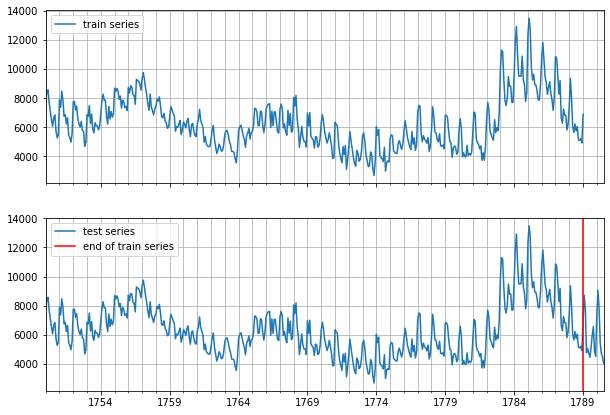

In [20]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [21]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

In [22]:
print(dataname)
epochs=200
num_batches = 100

mx.random.seed(44)
np.random.seed(44)

trainer = Trainer(
    ctx=mx.cpu(0),
    epochs=epochs,
    num_batches_per_epoch=num_batches,
    learning_rate=1e-3,
)

estimator = DeepAREstimator(
    trainer=trainer,
    cardinality= [
        feat_static_cat.cardinality 
        for feat_static_cat in dataset.metadata.feat_static_cat
    ],
#     context_length=dataset.metadata.prediction_length,
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    use_feat_static_cat=True
)

predictor = estimator.train(training_data=dataset.train)

forecast_it, ts_it = make_evaluation_predictions(
    dataset.test, predictor=predictor, num_samples=100
    )

agg_metrics, item_metrics = Evaluator()(
    ts_it, forecast_it, num_series=len(dataset.test)
)

m4_monthly_id


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.06it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 14.248 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.348879
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:18<00:00,  5.50it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 18.177 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.613137
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.89it/s, avg_epoch_loss=6.96]
INFO:root:Epoch[2] Elapsed time 14.509 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.963809
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.49it/s, avg_epoch_loss=7.11]
INFO:root:Epoch[3] Elapsed time 10.536 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.110910
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.79it/s, a

INFO:root:Epoch[35] Evaluation metric 'epoch_loss'=6.466053
INFO:root:Epoch[36] Learning rate is 0.00025
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[36] Elapsed time 11.609 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.588979
INFO:root:Epoch[37] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.02it/s, avg_epoch_loss=6.12]
INFO:root:Epoch[37] Elapsed time 12.492 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.115603
INFO:root:Epoch[38] Learning rate is 0.00025
100%|██████████| 100/100 [00:16<00:00,  5.89it/s, avg_epoch_loss=7.14]
INFO:root:Epoch[38] Elapsed time 16.993 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=7.137535
INFO:root:Epoch[39] Learning rate is 0.00025
100%|██████████| 100/100 [00:26<00:00,  3.80it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[39] Elapsed time 26.335 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=7.326012
INFO:root:Epoch[40] Learning rate is 0.00025

INFO:root:Epoch[71] Evaluation metric 'epoch_loss'=7.123969
INFO:root:Epoch[72] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:11<00:00,  8.47it/s, avg_epoch_loss=7]  
INFO:root:Epoch[72] Elapsed time 11.802 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.999464
INFO:root:Epoch[73] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:12<00:00,  7.76it/s, avg_epoch_loss=6.21]
INFO:root:Epoch[73] Elapsed time 12.926 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.206697
INFO:root:Epoch[74] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:12<00:00,  8.24it/s, avg_epoch_loss=7.22]
INFO:root:Epoch[74] Elapsed time 12.144 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=7.218632
INFO:root:Loading parameters from best epoch (64)
INFO:root:Epoch[75] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.58it/s, avg_epoch_loss=7.05]
INFO:root:Epoch[75] Elapsed time 11.665 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=7.0

100%|██████████| 100/100 [00:12<00:00,  7.79it/s, avg_epoch_loss=7.04]
INFO:root:Epoch[108] Elapsed time 12.848 seconds
INFO:root:Epoch[108] Evaluation metric 'epoch_loss'=7.044844
INFO:root:Epoch[109] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.08it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[109] Elapsed time 12.390 seconds
INFO:root:Epoch[109] Evaluation metric 'epoch_loss'=5.733461
INFO:root:Epoch[110] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.36it/s, avg_epoch_loss=6.4]
INFO:root:Epoch[110] Elapsed time 11.955 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=6.400352
INFO:root:Epoch[111] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=6.13]
INFO:root:Epoch[111] Elapsed time 11.615 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=6.128780
INFO:root:Epoch[112] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.52it/s, avg_epoch_loss=6.11]
INFO:root:Epoch[112] Elapsed t

INFO:root:Epoch[144] Elapsed time 16.315 seconds
INFO:root:Epoch[144] Evaluation metric 'epoch_loss'=6.294004
INFO:root:Epoch[145] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.45it/s, avg_epoch_loss=6.18]
INFO:root:Epoch[145] Elapsed time 11.840 seconds
INFO:root:Epoch[145] Evaluation metric 'epoch_loss'=6.175218
INFO:root:Epoch[146] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  8.00it/s, avg_epoch_loss=6.95]
INFO:root:Epoch[146] Elapsed time 12.499 seconds
INFO:root:Epoch[146] Evaluation metric 'epoch_loss'=6.947259
INFO:root:Epoch[147] Learning rate is 5e-05
100%|██████████| 100/100 [00:13<00:00,  7.23it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[147] Elapsed time 13.835 seconds
INFO:root:Epoch[147] Evaluation metric 'epoch_loss'=6.700281
INFO:root:Epoch[148] Learning rate is 5e-05
100%|██████████| 100/100 [00:15<00:00,  6.51it/s, avg_epoch_loss=5.94]
INFO:root:Epoch[148] Elapsed time 15.370 seconds
INFO:root:Epoch[148] Evaluation metric 'epoch_loss'=

INFO:root:Epoch[180] Evaluation metric 'epoch_loss'=6.846036
INFO:root:Epoch[181] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  7.90it/s, avg_epoch_loss=5.54]
INFO:root:Epoch[181] Elapsed time 12.658 seconds
INFO:root:Epoch[181] Evaluation metric 'epoch_loss'=5.544230
INFO:root:Epoch[182] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.38it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[182] Elapsed time 11.938 seconds
INFO:root:Epoch[182] Evaluation metric 'epoch_loss'=6.418372
INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:12<00:00,  7.83it/s, avg_epoch_loss=6.99]
INFO:root:Epoch[183] Elapsed time 12.789 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=6.989000
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:11<00:00,  8.72it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[184] Elapsed time 11.470 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.532907
INFO:root:Epoch[185] Learning rate is 5

In [23]:
metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

pd.DataFrame([output])

,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9]
0,1.030953,0.136102,13.546759,0.121055,0.078898


In [24]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,M1,1.095974e+06,15726.158203,105350.0,5852.777778,759.649891,1.150103,0.145488,19.225288,4889.800684,...,15726.158691,0.555556,16513.932812,0.611111,16514.807031,0.611111,15422.421289,0.611111,11903.139453,0.611111
1,M2,1.242935e+05,5902.005859,31580.0,1754.444444,356.345733,0.920144,0.178708,8.676273,2415.364526,...,5902.006470,0.888889,5443.314551,0.888889,4809.822070,0.944444,3860.729590,0.944444,2339.068164,1.000000
2,M3,1.159234e+05,5060.426758,248883.0,13826.833333,285.568928,0.984473,0.020486,4.484220,2625.886914,...,5060.426758,0.000000,4646.589453,0.055556,3679.999609,0.166667,1821.507031,0.444444,759.879492,0.833333
3,M4,7.786605e+04,4553.644531,115617.0,6423.166667,143.842857,1.758727,0.038615,7.762747,1168.883398,...,4553.644531,0.944444,5061.811719,1.000000,5060.062207,1.000000,4202.983789,1.000000,2850.933301,1.000000
4,M5,3.717417e+03,1096.707031,78630.0,4368.333333,111.000000,0.548902,0.013948,3.931989,688.060352,...,1096.707031,0.666667,1201.012500,0.666667,1173.258984,0.777778,1070.695312,0.888889,801.860547,0.944444


In [25]:
item_metrics.to_csv("m4_monthly_id_deepar_metrics_owa0957.csv")